In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.22.2
!pip install roboflow

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-2B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.10: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
from roboflow import Roboflow
from datasets import Dataset
import os
import glob
import yaml
from PIL import Image

# Download the dataset from Roboflow
rf = Roboflow(api_key="Qu018ajUkOv8KH7Zpl7O")
project = rf.workspace("sejong-x037c").project("fire-smoke-f1fv1")
version = project.version(1)
roboflow_dataset = version.download("yolov11")

# Get the location of the downloaded dataset
dataset_location = roboflow_dataset.location

# Load class names from data.yaml
with open(os.path.join(dataset_location, "data.yaml"), "r") as f:
    config = yaml.safe_load(f)
names = config["names"]

# Prepare the train split (adjust for other splits if needed)
train_path = os.path.join(dataset_location, "train")
image_files = glob.glob(os.path.join(train_path, "images", "*"))

data_list = []

for img_path in image_files:
    # Get corresponding label path
    base_name = os.path.basename(img_path)
    label_path = os.path.join(train_path, "labels", base_name.rsplit(".", 1)[0] + ".txt")

    if not os.path.exists(label_path):
        text = ""
    else:
        with open(label_path, "r") as f:
            lines = f.readlines()

        boxes = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, cx, cy, w, h = map(float, parts)
            x1 = max(0, min(999, int((cx - w / 2) * 1000)))
            y1 = max(0, min(999, int((cy - h / 2) * 1000)))
            x2 = max(0, min(999, int((cx + w / 2) * 1000)))
            y2 = max(0, min(999, int((cy + h / 2) * 1000)))
            class_name = names[int(cls)]
            boxes.append(f"{class_name}<loc{x1}><loc{y1}><loc{x2}><loc{y2}>")

        text = " ".join(boxes)

    # Load image
    image = Image.open(img_path)

    data_list.append({"image": image, "text": text})

# Create the Hugging Face Dataset
dataset = Dataset.from_list(data_list)

# Now you can use custom_dataset like the loaded LaTeX_OCR dataset
# For example: custom_dataset[0]["image"], custom_dataset[0]["text"]
# To fine-tune Qwen2-VL (or similar Qwen3-VL if available), use this dataset with a library like unsloth,
# where the 'text' field represents the grounding output with bounding boxes in <locN> format (normalized to 0-999).
# The bounding boxes are represented in the text as class_name<loc_x1><loc_y1><loc_x2><loc_y2>,
# which is a common grounding format for VLMs.

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6260
})

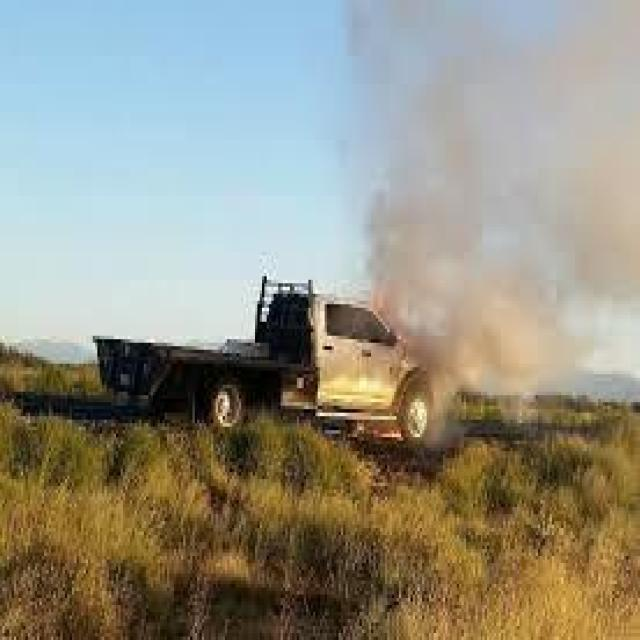

In [ ]:
dataset[2]["image"]

In [ ]:
dataset[2]["text"]

'smoke<loc583><loc92><loc944><loc563>'

In [ ]:
from IPython.display import display, Math, Latex

latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

In [ ]:
instruction = "detect fire bbox"

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'detect fire bbox'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'other<loc283><loc230><loc758><loc702>'}]}]}

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [ ]:
trainer_stats = trainer.train()